<a href="https://colab.research.google.com/github/componavt/differential_equations/blob/main/src/hill_equation/deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Network Solution for Hill Equation  
**Goal**: Solve the Hill ODE numerically using DeepXDE.  

- **Equation**: `dx/dt = x^(1/α) / (b^(1/α) + x^(1/α))`  
- **Conditions**:  
  - `α → 0` (small, stiff regime)  
  - `x(0) ≈ b` (initial condition)  
- **Method**:  
  - Neural PDE solver (4-layer FNN, tanh activation).  
  - Adam optimizer (LR=0.001).  
- **Output**: Predicted `x(t)` vs. approximate exact solution.  

In [ ]:
# Параметры
alpha = 0.01
b = 1.0
x0 = b * 0.99999  # Начальное условие x(0) ≈ b

!pip install deepxde
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Compiling model...
Building feed-forward neural network...
'build' took 0.099290 s

'compile' took 0.709149 s

Training model...

Step      Train loss              Test loss               Test metric
0         [7.18e-01, 1.00e+00]    [6.95e-01, 1.00e+00]    []  
1000      [5.32e-04, 1.02e-03]    [5.10e-04, 1.02e-03]    []  
2000      [4.96e-04, 9.91e-04]    [4.63e-04, 9.91e-04]    []  
3000      [2.24e-02, 1.66e-02]    [2.20e-02, 1.66e-02]    []  
4000      [5.60e-04, 1.07e-03]    [5.47e-04, 1.07e-03]    []  
5000      [5.20e-04, 1.03e-03]    [4.98e-04, 1.03e-03]    []  

Best model at step 2000:
  train loss: 1.49e-03
  test loss: 1.45e-03
  test metric: []

'train' took 14.494008 s



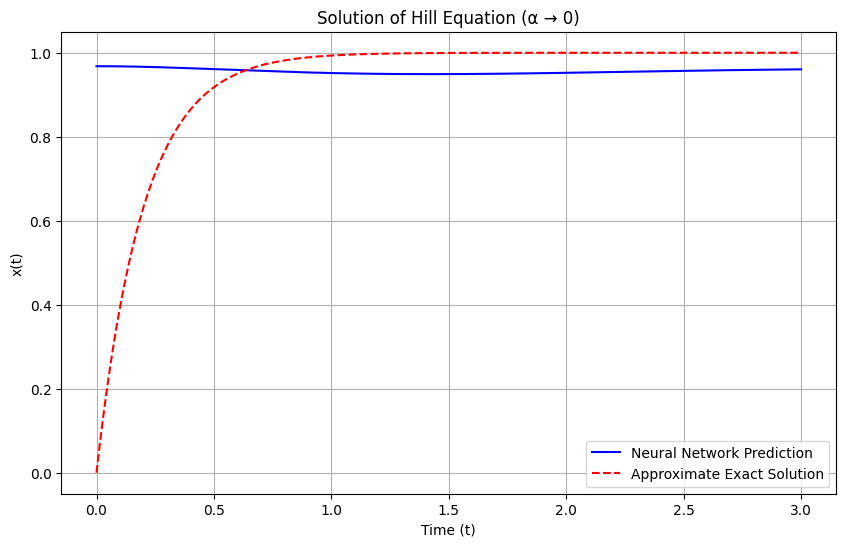

In [4]:
# Определение уравнения Хилла
def hill_equation(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=0)
    x_alpha = tf.pow(y, 1/alpha)
    b_alpha = tf.pow(b, 1/alpha)
    return dy_t - x_alpha / (b_alpha + x_alpha)

# Геометрия временного интервала
geom = dde.geometry.TimeDomain(0, 3)

# Начальное условие
ic = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

# Данные для обучения
data = dde.data.PDE(
    geom,
    hill_equation,
    ic,
    num_domain=100,
    num_boundary=2,
    num_test=300
)

# Архитектура нейросети
model = dde.Model(data, dde.nn.FNN([1] + [32] * 4 + [1], "tanh", "Glorot normal"))

# Компиляция и обучение
model.compile("adam", lr=0.001)
model.train(iterations=5000, display_every=1000)

# Предсказание модели на тестовых данных
t_test = np.linspace(0, 3, 300).reshape(-1, 1)
x_pred = model.predict(t_test)

# Приближенное "точное" решение (пример)
# Для alpha → 0 уравнение становится ступенчатой функцией.
# При x(0) ≈ b решение быстро растет к насыщению.
x_exact_approx = b * (1 - np.exp(-5 * t_test))  # Примерная аппроксимация

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_pred, 'b-', label='Neural Network Prediction')
plt.plot(t_test, x_exact_approx, 'r--', label='Approximate Exact Solution')
plt.xlabel('Time (t)')
plt.ylabel('x(t)')
plt.title('Solution of Hill Equation (α → 0)')
plt.legend()
plt.grid(True)
plt.show()